___

<a href='https://github.com/eliasmelul/'> <img src='https://s3.us-east-2.amazonaws.com/wordontheamazon.com/BlueLogoNoBackground.png' style='width: 8em;' align='right' /></a>
# Capstone Project: Looking for my Schitt's Creek
___
<h3 align="right">by Elias Melul, Data Scientist </h3> 

___



<h2 id = "BusinessUnderstanding">Business Understanding</h2>

The purpose of this capstone project is quite simple, and one that many people have encountered.
_______________________________________________________________________________________________________________________

Most of us have heard of New York City, Boston, San Francisco, Chicago, Miami... all very different cities with a lot to offer. However, there are many incredible cities in the United States, cities that we might not know much about, nor we learn about until someone introduces us to it!

As an international student in the US, I constantly wonder if my desire to go to one of the big cities (NYC, Boston, San Fran. etc.) is valid and if there are other places in the US that I may not know of. I go to Duke University, and I really liked Raleigh-Durham. Had I not gone there, I would not have known!

-------------------

So I am going to classify the cities based on an amalgalm of features to see which one are statistically most similar than others. I will also attempt to build a recommendator system that takes your favorite cities (and least favorites!) and the rating you give them and return other cities with similar characteristics. Feel free to try it out!

<h2 id = "DataCollection">Data Collection</h2>

In order to create a good clustering model and a competent recommender system, I need information from cities in the USA, and lots of it! 

----
**Which cities will I include?**

I found [this](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) Wikipedia site that includes a table of the top 314 most populated cities in the USA. We will use these cities to scrape the web, leverage FourSquare API, and gather as much data as possible to feed to our classificator model and our recommender system.

----
**What data will be collected and how?**

There is a CRAZY amount of data available on the web about all cities, but these can be very dispar and from numerous websites. Lucky me, I found [this](https://datausa.io/) website that contains most the information I need (thank you Deloitte and Datawheel!), so I will selectively choose to scrape metrics that I believe might be important. I will then combine this information with FourSquare information about venues and others to complete the dataframe and begin modeling!

**Some of the variables scraped are:**

* Population and Population Change (Year to Year)
* Poverty Rate
* Median Age
* Median Household Income and Median Household Income Change (Year to Year)
* Number of Employees and Number of Employees Change (Year to Year)
* Median Property Value and Median Property Value Change (Year to Year)
* Average Male and Female Salary, and a ratio of Average Male to Female Salary
* Gini coefficient in 2017 and 2018, as well as it's change (Year to Year)
* Ratio of Patients to Clinicians (county-wise)
* Foreign-born population percentage
* Citizen population percentage
* Total degrees awarded in 2018 (higher education)
* Male to Female ratio of awarded degrees
* Number of degrees per capita
* Number of households in city
* Population per household (people per household)
* Homeownership Percentage (Rent vs Own)
* Average Commute Time (minutes)

#### Import Libraries

In [21]:
import pandas as pd # import pandas for dataframes
import numpy as np
import requests
from bs4 import BeautifulSoup
import locale
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors

from IPython.display import HTML, display
from IPython.display import Image 
from IPython.core.display import HTML 

pd.options.display.max_columns = None
pd.options.display.max_rows=None


%matplotlib inline

<h3 id ="GettingList">Getting List of Cities</h3>

#### Load Wikipedia Data for City Names

In [22]:
all_cities = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population')[4]
all_cities.head()

,2018rank,City,State[c],2018estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York[d],New York,8398748,8175133,+2.74%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,2,Los Angeles,California,3990456,3792621,+5.22%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2705994,2695598,+0.39%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston[3],Texas,2325502,2100263,+10.72%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1660272,1445632,+14.85%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


There are three clear problems with the imported table above:
1. **Some of the city names have square brakets due to footnotes included in the table. We must get rid of them.**
2. **The state column is not abbreviated. Why is this an issue? Because of the url format datausa.io has. This will become clear in the next section.**
3. **The format of the values for each city is not adequate. We need to convert number to numeric.**

**Lets fix problem 1: deleting everything within square brakets in the City column.**

In [23]:
for i, row in all_cities.iterrows():
    ifor_val = re.sub(r'\[.*\]', '', row.City)
    all_cities.at[i,'City'] = ifor_val
all_cities.head()

,2018rank,City,State[c],2018estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York,New York,8398748,8175133,+2.74%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,2,Los Angeles,California,3990456,3792621,+5.22%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2705994,2695598,+0.39%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston,Texas,2325502,2100263,+10.72%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1660272,1445632,+14.85%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


Lets also rename the columns and subset the data to the useful columns.

In [24]:
all_cities.rename(columns={'2018rank':'Rank',
                  'State[c]':'State',
                  '2018estimate':'Population_2018',
                  '2010Census':'Population_2010',
                  '2016 land area.1':'Land_Area_km2',
                  '2016 population density.1':'Population_Density_per_km2'}, inplace=True)


all_cities = all_cities[['City','State','Land_Area_km2','Population_Density_per_km2', 'Location']]
all_cities.head()

,City,State,Land_Area_km2,Population_Density_per_km2,Location
0,New York,New York,780.9 km2,"10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,Los Angeles,California,"1,213.9 km2","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,Chicago,Illinois,588.7 km2,"4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,Houston,Texas,"1,651.1 km2","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,Phoenix,Arizona,"1,340.6 km2","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


**Lets fix problem 2: Adding State abbreviations**

To add the abbreviations, we must get a list of abbreviations and their respective states spelled out. Luckily, Wikipedia has a site listing all the US abbreviations! We will first import them, and then add the appropiate abbreviation to each City in our dataframe.

In [25]:
abb_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations', skiprows=11)[0]
abb_df = abb_df[['United States of America', 'Unnamed: 5']]
abb_df = abb_df.rename(columns={'United States of America':'State','Unnamed: 5':'State_Abb'})
abb_df.head()

,State,State_Abb
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [26]:
all_cities = all_cities.merge(abb_df, on='State')
all_cities.tail()

,City,State,Land_Area_km2,Population_Density_per_km2,Location,State_Abb
311,Columbia,South Carolina,345.8 km2,388/km2,34°01′45″N 80°53′53″W﻿ / ﻿34.0291°N 80.8980°W,SC
312,North Charleston,South Carolina,190.9 km2,573/km2,32°55′04″N 80°03′54″W﻿ / ﻿32.9178°N 80.0650°W,SC
313,Fargo,North Dakota,127.7 km2,950/km2,46°51′55″N 96°49′44″W﻿ / ﻿46.8652°N 96.8290°W,ND
314,Manchester,New Hampshire,85.7 km2,"1,289/km2",42°59′06″N 71°26′39″W﻿ / ﻿42.9849°N 71.4441°W,NH
315,Billings,Montana,113.2 km2,975/km2,45°47′19″N 108°33′00″W﻿ / ﻿45.7885°N 108.5499°W,MT


**Lets fix problem 3: Formatting column contents**

In [27]:
for i, row in all_cities.iterrows():
    all_cities.at[i,'Land_Area_km2'] = float(row.Land_Area_km2[0:-4].replace(',',''))
    all_cities.at[i,'Population_Density_per_km2'] = float(row.Population_Density_per_km2[0:-4].replace(',',''))
all_cities.head()

,City,State,Land_Area_km2,Population_Density_per_km2,Location,State_Abb
0,New York,New York,780.9,10933,40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W,NY
1,Buffalo,New York,104.6,2455,42°53′33″N 78°51′35″W﻿ / ﻿42.8925°N 78.8597°W,NY
2,Rochester,New York,92.7,2253,43°10′12″N 77°37′01″W﻿ / ﻿43.1699°N 77.6169°W,NY
3,Yonkers,New York,46.6,4307,40°56′45″N 73°52′03″W﻿ / ﻿40.9459°N 73.8674°W,NY
4,Syracuse,New York,64.7,2214,43°02′28″N 76°08′37″W﻿ / ﻿43.0410°N 76.1436°W,NY


In [28]:
#Lets also create a column with standard city namage: New York, NY
all_cities = all_cities.rename(columns={'City':'City Name'})
all_cities['City'] = [row['City Name']+", "+row['State_Abb'] for i,row in all_cities.iterrows()]
all_cities.head()

,City Name,State,Land_Area_km2,Population_Density_per_km2,Location,State_Abb,City
0,New York,New York,780.9,10933,40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W,NY,"New York, NY"
1,Buffalo,New York,104.6,2455,42°53′33″N 78°51′35″W﻿ / ﻿42.8925°N 78.8597°W,NY,"Buffalo, NY"
2,Rochester,New York,92.7,2253,43°10′12″N 77°37′01″W﻿ / ﻿43.1699°N 77.6169°W,NY,"Rochester, NY"
3,Yonkers,New York,46.6,4307,40°56′45″N 73°52′03″W﻿ / ﻿40.9459°N 73.8674°W,NY,"Yonkers, NY"
4,Syracuse,New York,64.7,2214,43°02′28″N 76°08′37″W﻿ / ﻿43.0410°N 76.1436°W,NY,"Syracuse, NY"


In [29]:
#Lastly, we need to format the location. First, note that the location includes the latitude and longitude in two different formats.
for i, row in all_cities.iterrows():
    item = row.Location.split("/")[1].replace("°","").strip().split(" ")
    latitude = item[0][1:]
    longitude = item[1]
    if longitude[-1:] == "W":
        longitude = float(longitude[:-1])*-1
    else:
        longitude = float(longitude[:-1])
        
    if latitude[-1:] == "S":
        latitude = float(latitude[:-1])*-1
    else:
        latitude = float(latitude[:-1])
    
    all_cities.at[i,'Latitude'] = latitude
    all_cities.at[i,'Longitude'] = longitude

all_cities = all_cities.drop('Location', axis=1)

In [30]:
all_cities.head()

,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,City,Latitude,Longitude
0,New York,New York,780.9,10933,NY,"New York, NY",40.6635,-73.9387
1,Buffalo,New York,104.6,2455,NY,"Buffalo, NY",42.8925,-78.8597
2,Rochester,New York,92.7,2253,NY,"Rochester, NY",43.1699,-77.6169
3,Yonkers,New York,46.6,4307,NY,"Yonkers, NY",40.9459,-73.8674
4,Syracuse,New York,64.7,2214,NY,"Syracuse, NY",43.0410,-76.1436


Great! Now that these problems have been fixed, we can proceed to scraping the web for more data! 

---
For that, we will need a list of all the cities and their respective state abbreviation. Why? Because the path to our scrapping website is as follows:

    /city-name-state_abbretiation
    
    For example:
    /new-york-ny
 

However, not all URLs are that clear. Some contain paths that include 'metropolitan area' or some require a 'county'. For that reason, we will generate URLs that also include the following forms:

    /new-york-ny-metro-area
    /new-york-county-ny

Once we generate these URLs, we will check if they are valid, extract another list of only valid URLs and use those to scrape data.

#### Generating the URLs

In [31]:
cities_list = all_cities['City Name'] + " "+all_cities.State_Abb
cities_list = list(cities_list)
cities_list= [i.lower().replace(' ','-') for i in cities_list]

In [32]:
# Add -metro-area
cities_metro = [i+'-metro-area' for i in cities_list]

In [33]:
# #Add county possible urls
# county_list = all_cities['City Name'] +"-county-"+all_cities.State_Abb
# county_list = [i.lower().replace(' ','-') for i in county_list]

In [34]:
# Combine the lists
cities_list=cities_list+cities_metro#+county_list

In [35]:
#Concatenate the domain to the generated path to recreate all the URLS
urls_cities = ["https://datausa.io/profile/geo/"+i for i in cities_list]

In [36]:
len(urls_cities)

632

We have generated 632 possible URLs to scrap the data.

Let's check how many of them are valid and keep those for scraping.

In [45]:
#Check if url connections exist
checker = []
for url in urls_cities:
    c = requests.get(url)
    soup = BeautifulSoup(c.content, features='lxml')
    res = soup.find_all("h4",{"class":"pt-non-ideal-state-title"})
    if (len(res) > 0):
        exist = 0
    else:
        try:
            tes = soup.find("div",{"class":"content-container"})
            tes = tes.get_text()
            if (tes == 'N/A'):
                exist = 0
            else:
                exist =1
        except: 
            exist=1
            pass
           
    tempdic = {"URL":url,
              "Exist":exist}
    checker.append(tempdic)

checker = pd.DataFrame(checker)
checker.head()

,URL,Exist
0,https://datausa.io/profile/geo/new-york-ny,1
1,https://datausa.io/profile/geo/buffalo-ny,1
2,https://datausa.io/profile/geo/rochester-ny,1
3,https://datausa.io/profile/geo/yonkers-ny,1
4,https://datausa.io/profile/geo/syracuse-ny,1


In [46]:
existing = checker[checker.Exist==1]
print(f"The number of valid URLs is: {existing.shape[0]}")
nonexisting = checker[checker.Exist==0]
print(f"The number of invalid URLs is: {nonexisting.shape[0]}")

The number of valid URLs is: 373
The number of invalid URLs is: 259


In [47]:
#Create a list with the existing
urls_cities = existing['URL'].to_list()

As we can see, there are 373 URLs from our generated URL list. 

If we recall, there were only 314 cities on our list... it seems likely that have a lot repeat cities/areas due to the 'County' and 'Metro-Area' paths added. We will deal with this issue after scraping.

---
For now, let's have some fun!

#### Scraping dataUSA

For this section, we have defined everyhing as functions, so that we can easily iterate over all the URLs. 

---
The first function simply retrieves the text data from the HTML section specified by the class types and names.

---

The second function uses the first function to retrieve each metric wanted for each city as strings, and transforms such to the type desired. In this case, all the information is numeric except the name of the city. A dictionary will be returned.


In [48]:
def get_text_from_class(soup,classname,type1="div",type2="class"):
    city_content = soup.find(type1, {type2:classname})
    city_info = city_content.find_all('p')
    content_raw = []
    for i in city_info:
        i = str(i)
        removefirst = i[3:-4]
        content_raw.append(removefirst)
    return(content_raw)

In [49]:
def get_basic_city_info(url):
    html = requests.get(url=url)
    soup = BeautifulSoup(html.content, features='lxml')
    
    ###### Get content from dashboard
    #Name of the city
    city_name = soup.find("p").get_text()
    
    #Raw dashboard content
    content_raw = get_text_from_class(soup, "profile-stats")
    
    #Population of City
    Population = content_raw[1]
    
    if Population[-1:] == "M":
        Population = float(Population[0:-1])*1000000
    else:
        Population = float(Population.replace(',',''))
    
    #Population Change YTY
    Population_Change = content_raw[2]
    if Population_Change[-7:] == 'decline':
        Population_Change = float(Population_Change[0:-9])*-1
    else:
        Population_Change = float(Population_Change[0:-8])
        
    #Poverty Rate
    Poverty_Rate = float(content_raw[4][0:-1])
    
    #Median Age
    Median_Age = float(content_raw[7])
    
    #Median Household Income and Change
    Median_Household_Income = float(content_raw[10][1:].replace(',',''))
    Median_Household_Income_Change = content_raw[11]
    if Median_Household_Income_Change[-7:]=='decline':
        Median_Household_Income_Change = float(Median_Household_Income_Change[0:-9])*-1
    else:
        Median_Household_Income_Change = float(Median_Household_Income_Change[0:-8])
    
    #Number of Employees
    Number_Employees = content_raw[13]
    if Number_Employees[-1:] == "M":
        Number_Employees = float(Number_Employees[0:-1])*1000000
    else:
        Number_Employees = float(Number_Employees.replace(',',''))
    
    #Change Number of Employees
    Number_Employees_Change = content_raw[14]
    if Number_Employees_Change[-7:]=='decline':
        Number_Employees_Change = float(Number_Employees_Change[0:-9])*-1
    else:
        Number_Employees_Change = float(Number_Employees_Change[0:-8])
    
    #Median Property Value
    Median_Property_Value = content_raw[16][1:]
    if Median_Property_Value[-1:] == "M":
        Median_Property_Value = float(Median_Property_Value[0:-1])*1000000
    else:
        Median_Property_Value = float(Median_Property_Value.replace(',',''))
    
    #Median Property Value Change
    Median_Property_Value_Change = content_raw[17]
    if Median_Property_Value_Change[-7:]=='decline':
        Median_Property_Value_Change = float(Median_Property_Value_Change[0:-9])*-1
    else:
        Median_Property_Value_Change = float(Median_Property_Value_Change[0:-8])
    
    #Wage Distribution across genders
    wage_gender = get_text_from_class(soup, "topic income_gender TextViz")
    avg_male_salary = float(wage_gender[2][1:].replace(',',''))
    avg_female_salary = float(wage_gender[5][1:].replace(',',''))
    gender_salary_ratio = avg_male_salary/avg_female_salary
  
    #Gini coefficient distribution
    gini_coeff = get_text_from_class(soup, "topic income_distro TextViz")
    gini_2018 = float(gini_coeff[2])
    gini_2017 = float(gini_coeff[4])
    gini_change_percent = (gini_2018-gini_2017)*100/gini_2017
    
    #Health Ratio (Patients to Clinicians)
    health_ratio = get_text_from_class(soup, "topic clinician_patient_ratio TextViz")
    health_ratio = float(health_ratio[2].replace(' to 1','').replace(',',''))
    
    #Foreign Born Population
    foreign_ratio = get_text_from_class(soup, "topic foreign_born TextViz")
    foreign_ratio = float(foreign_ratio[1][:-1].replace(',',''))
    
    #Citizen Ratio
    citizen_ratio = get_text_from_class(soup, "topic citizenship TextViz")
    citizen_ratio = float(citizen_ratio[1][:-1].replace(',',''))
    
    #Degrees awareded
    # There seem to be some cities without education infomration... we need to handle this exception
    try:
        degrees_awarded = get_text_from_class(soup, "topic edu_gender TextViz")
        degrees_men = float(degrees_awarded[1].replace(',',''))
        degrees_women = float(degrees_awarded[3].replace(',',''))
        degrees_gender_ratio_M2F = degrees_men/degrees_women 
        total_degrees = degrees_men+degrees_women
        degrees_per_capita = total_degrees/Population
    except:
        total_degrees = 0
        degrees_gender_ratio_M2F = 1
        degrees_per_capita = None
    
    #Number of Households
    households = get_text_from_class(soup, "topic household_income TextViz")
    households = households[5]
    if households[-1:] == "M":
        households = float(households[0:-1])*1000000
    elif households[-1:]=="k":
        households = float(households[0:-1])*1000
    else:
        households = float(households.replace(',',''))
    people_per_house = Population/households
    
    #Rent vs Ownership of Homes
    rent_own = get_text_from_class(soup, "topic rent_own TextViz")
    rent_own = float(rent_own[1][:-1])
    
    #Communite time
    commute_time = get_text_from_class(soup, "topic commute_time TextViz")
    commute_time = float(commute_time[1][:-8])
    
    basic_information = {'City':city_name,
                        'Population':Population,
                        'Population Change':Population_Change,
                        'Poverty Rate':Poverty_Rate,
                        'Median Age':Median_Age,
                        'Median Household Income':Median_Household_Income,
                        'Median Household Income Change':Median_Household_Income_Change,
                        'Number Employees':Number_Employees,
                        'Number Employees Change':Number_Employees_Change,
                        'Median Property Value':Median_Property_Value,
                        'Median Property Value Change':Median_Property_Value_Change,
                        'Average Male Salary':avg_male_salary,
                        'Average Female Salary':avg_female_salary,
                        'Gender Salary Ratio M2F':gender_salary_ratio,
                        'Gini 2018':gini_2018,
                        'Gini Change':gini_change_percent,
                        'Patient to Clinician Ratio':health_ratio,
                        'Foreign Born Population Ratio':foreign_ratio,
                        'Citizens Percentage':citizen_ratio,
                        'Total Degrees':total_degrees,
                        'Degrees Ratio M2F':degrees_gender_ratio_M2F,
                        'Degrees per Capita':degrees_per_capita,
                        'Households':households,
                        'People Per House':people_per_house,
                        'Homeownership':rent_own,
                        'Commute Time':commute_time}
    
    
    return basic_information

##### Functions Use Example

We will use NYC to see how the functions work and how the output looks.

In [50]:
url = 'https://datausa.io/profile/geo/new-york-ny'

In [51]:
get_basic_city_info(url)

{'City': 'New York, NY',
 'Population': 8400000.0,
 'Population Change': -2.6,
 'Poverty Rate': 19.6,
 'Median Age': 36.9,
 'Median Household Income': 63799.0,
 'Median Household Income Change': 4.8,
 'Number Employees': 4090000.0,
 'Number Employees Change': -2.21,
 'Median Property Value': 645100.0,
 'Median Property Value Change': 5.84,
 'Average Male Salary': 81735.0,
 'Average Female Salary': 63914.0,
 'Gender Salary Ratio M2F': 1.2788277998560567,
 'Gini 2018': 0.493,
 'Gini Change': -0.8048289738430591,
 'Patient to Clinician Ratio': 1553.0,
 'Foreign Born Population Ratio': 36.9,
 'Citizens Percentage': 84.3,
 'Total Degrees': 147053.0,
 'Degrees Ratio M2F': 0.608367056764738,
 'Degrees per Capita': 0.017506309523809525,
 'Households': 3180000.0,
 'People Per House': 2.641509433962264,
 'Homeownership': 32.8,
 'Commute Time': 40.1}

**Now that we have defined these functions, lets iterate over all our valid URLs to extract the specified metrics**

While running through the iterations of each city URL, there were some probleatic valid URLs. Take [Louisville, KY](https://datausa.io/profile/geo/louisville-ky) as an example. It does not contain the dashboard we typically use to extract some of the basic information. In addition, if has a bunch of NAs in the values we scrape from other parts of the website. Hence we are going to take these problematic URLs off the list.

---
**Dropping specific URLs**

In [52]:
urls_cities.remove('https://datausa.io/profile/geo/louisville-ky')

**Iterate over all valid URLs and extract all the information specified in our function**

In [53]:
cities_basic = []
for url in urls_cities:
    data = get_basic_city_info(url)
    cities_basic.append(data)

In [54]:
len(cities_basic)

372

In [55]:
cities = pd.DataFrame(cities_basic)
print(cities.shape)
cities.head()

(372, 26)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"New York, NY",8400000.0,-2.6000,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1
1,"Buffalo, NY",256322.0,-0.8780,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9
2,"Rochester, NY",209463.0,-0.3940,33.1,31.7,32347.0,2.09,90549.0,1.620,79400.0,2.060,76804.0,59246.0,1.296358,0.499,0.402414,966.0,8.71,94.9,3985.0,0.933527,0.019025,86200.0,2.429965,36.5,19.5
3,"Yonkers, NY",200999.0,0.6380,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3
4,"Syracuse, NY",144405.0,0.0381,32.6,30.6,34716.0,6.15,58724.0,0.118,91100.0,1.330,76804.0,59246.0,1.296358,0.499,0.402414,1050.0,12.50,92.1,8707.0,0.784953,0.060296,55600.0,2.597212,38.3,17.8


Amazing! We have scraped information about 372 cities and/or metropolitan areas - all containing 26 metrics that may be useful in our segmentation and recommendation problem.

Before we join the two tables, there is a critical issue to resolve: we have more rows in the scraped dataframe than we have cities on our list!

In [56]:
dupli = cities[cities.duplicated()] #Gets duplicated rows - where the WHOLE row is duplicated
dupli

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time


In [57]:
dupli = cities[cities['City'].duplicated(keep=False)]
dupli.shape
dupli.head()

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
2,"Rochester, NY",209463.0,-0.3940,33.1,31.7,32347.0,2.09,90549.0,1.620,79400.0,2.06,76804.0,59246.0,1.296358,0.499,0.402414,966.0,8.71,94.9,3985.0,0.933527,0.019025,86200.0,2.429965,36.5,19.5
4,"Syracuse, NY",144405.0,0.0381,32.6,30.6,34716.0,6.15,58724.0,0.118,91100.0,1.33,76804.0,59246.0,1.296358,0.499,0.402414,1050.0,12.50,92.1,8707.0,0.784953,0.060296,55600.0,2.597212,38.3,17.8
9,"Fresno, CA",530073.0,0.5030,28.4,31.5,49813.0,2.50,219244.0,0.037,257200.0,9.68,78575.0,62298.0,1.261276,0.499,0.402414,1533.0,19.90,90.3,9907.0,0.558440,0.018690,171000.0,3.099842,44.2,21.8
22,"Modesto, CA",210166.0,0.7930,17.0,35.3,54024.0,5.94,86370.0,3.270,236200.0,13.60,72235.0,57252.0,1.261703,0.500,0.000000,1525.0,18.10,90.8,2805.0,0.482558,0.013347,71400.0,2.943501,54.6,26.0
39,"Salinas, CA",156811.0,0.5910,17.2,30.2,54864.0,4.83,67547.0,0.551,342100.0,12.60,72235.0,57252.0,1.261703,0.500,0.000000,1702.0,37.80,70.8,1919.0,0.521808,0.012238,40600.0,3.862340,44.5,22.6


In [58]:
dupli = dupli.sort_values(by='Population', ascending=False)
dupli = dupli.reset_index().drop('index', axis=1)
dupli.head()

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"Pittsburgh, PA",2320000.0,-0.370,11.8,43.1,59710.0,2.030,1170000.0,0.509,160300.0,4.57,69779.0,52119.0,1.338840,0.469,-0.635593,1232.0,3.78,98.2,39982.0,0.763030,0.017234,1010000.0,2.297030,69.6,25.4
1,"Columbus, OH",2110000.0,1.340,14.0,36.1,64052.0,0.452,1070000.0,1.040,196700.0,7.90,65155.0,48520.0,1.342848,0.460,0.656455,1307.0,7.26,95.5,33833.0,0.778905,0.016035,802000.0,2.630923,61.9,22.5
2,"Jacksonville, FL",1530000.0,1.970,13.9,38.8,60238.0,2.600,727956.0,2.880,217200.0,5.90,62257.0,46612.0,1.335643,0.474,0.211416,1376.0,8.44,95.8,18224.0,0.709087,0.011911,575000.0,2.660870,63.5,25.2
3,"Oklahoma City, OK",1400000.0,0.918,14.6,35.3,57485.0,2.180,683637.0,2.550,160900.0,2.61,59946.0,41789.0,1.434492,0.465,3.563474,1587.0,7.85,94.9,22794.0,0.757305,0.016281,522000.0,2.681992,63.1,21.9
4,"Richmond, VA",1300000.0,0.160,12.4,38.8,67703.0,0.103,658555.0,1.150,246100.0,3.45,77546.0,58156.0,1.333414,0.480,0.628931,1316.0,7.23,95.6,16092.0,0.637363,0.012378,497000.0,2.615694,65.6,23.7


By sorting the data by population descending and reseting the index, we can now remove all duplicate rows based on their position. In other words, we can keep the first duplicate record - the metropolitan area one most likely.

In [59]:
dupli = dupli.drop_duplicates(subset='City',keep='first')
print(dupli.shape)
dupli.head()

(68, 26)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"Pittsburgh, PA",2320000.0,-0.370,11.8,43.1,59710.0,2.030,1170000.0,0.509,160300.0,4.57,69779.0,52119.0,1.338840,0.469,-0.635593,1232.0,3.78,98.2,39982.0,0.763030,0.017234,1010000.0,2.297030,69.6,25.4
1,"Columbus, OH",2110000.0,1.340,14.0,36.1,64052.0,0.452,1070000.0,1.040,196700.0,7.90,65155.0,48520.0,1.342848,0.460,0.656455,1307.0,7.26,95.5,33833.0,0.778905,0.016035,802000.0,2.630923,61.9,22.5
2,"Jacksonville, FL",1530000.0,1.970,13.9,38.8,60238.0,2.600,727956.0,2.880,217200.0,5.90,62257.0,46612.0,1.335643,0.474,0.211416,1376.0,8.44,95.8,18224.0,0.709087,0.011911,575000.0,2.660870,63.5,25.2
3,"Oklahoma City, OK",1400000.0,0.918,14.6,35.3,57485.0,2.180,683637.0,2.550,160900.0,2.61,59946.0,41789.0,1.434492,0.465,3.563474,1587.0,7.85,94.9,22794.0,0.757305,0.016281,522000.0,2.681992,63.1,21.9
4,"Richmond, VA",1300000.0,0.160,12.4,38.8,67703.0,0.103,658555.0,1.150,246100.0,3.45,77546.0,58156.0,1.333414,0.480,0.628931,1316.0,7.23,95.6,16092.0,0.637363,0.012378,497000.0,2.615694,65.6,23.7


In [60]:
cities = cities.drop_duplicates(subset='City', keep=False)
print(cities.shape)
cities.head()

(236, 26)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"New York, NY",8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1
1,"Buffalo, NY",256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9
3,"Yonkers, NY",200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3
5,"Los Angeles, CA",3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3
6,"San Diego, CA",1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5


In [61]:
cities = pd.concat([cities,dupli])
cities.shape

(304, 26)

Now that we have our data in the right format, lets do an inner join on the two dataframes that we want to combine on City and State abbreviation.

**Joining the Two Data Frames**

In [62]:
cities = cities.merge(all_cities,how='inner', left_on=['City'], right_on=['City'])
print(cities.shape)
cities.head()

(299, 33)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude
0,"New York, NY",8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,New York,New York,780.9,10933,NY,40.6635,-73.9387
1,"Buffalo, NY",256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,Buffalo,New York,104.6,2455,NY,42.8925,-78.8597
2,"Yonkers, NY",200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,Yonkers,New York,46.6,4307,NY,40.9459,-73.8674
3,"Los Angeles, CA",3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,Los Angeles,California,1213.9,3276,CA,34.0194,-118.4108
4,"San Diego, CA",1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,San Diego,California,842.3,1670,CA,32.8153,-117.1350


We seem to have lost 16 observations, a marginal effect of unstandardized naming convention among the scraped websited. 
___

**_If interested in exploring more about the relationships between the variables, please go to the <a id='ExplorationVariables'></a>[last section](#ExplorationVariables)._**

### Exploring Venue Information from Foursquare

**Define Foursquare Credentials**

In [63]:
CLIENT_ID = '1GFAHOQNHDJNYCFLI3EDIE1UHGZIJPVRTQIIRYVZGUXV1F23' # Foursquare ID
CLIENT_SECRET = 'KYZMRBJB11ZS1YJITM4M2X0NH3THZVHTV5OWKFCOY1EVTDQM' # Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1GFAHOQNHDJNYCFLI3EDIE1UHGZIJPVRTQIIRYVZGUXV1F23
CLIENT_SECRET:KYZMRBJB11ZS1YJITM4M2X0NH3THZVHTV5OWKFCOY1EVTDQM


##### Lets explore the venues is NYC

In [64]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 10000 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    float(cities[cities['City']=="New York, NY"]['Latitude']), 
    float(cities[cities['City']=="New York, NY"]['Longitude']), 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

In [65]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [66]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head()

(100, 4)


,name,categories,lat,lng
0,Glou,Tapas Restaurant,40.662949,-73.953869
1,Barboncino,Pizza Place,40.672104,-73.957412
2,Ix,Café,40.660844,-73.961344
3,Erv's On Beekman,Cocktail Bar,40.660003,-73.960935
4,Brooklyn Botanic Garden,Botanical Garden,40.667622,-73.963191


Now that we have been able to get the top 100 venues in NYC, let's replicate the process with all the cities in the cities dataframe.

In [67]:
def get_Nearby_Venues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [68]:
usa_venues = get_Nearby_Venues(names=cities.City, latitudes=cities.Latitude, longitudes=cities.Longitude)
print(usa_venues.shape)
usa_venues.head()

(29413, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",40.6635,-73.9387,Glou,40.662949,-73.953869,Tapas Restaurant
1,"New York, NY",40.6635,-73.9387,Barboncino,40.672104,-73.957412,Pizza Place
2,"New York, NY",40.6635,-73.9387,Ix,40.660844,-73.961344,Café
3,"New York, NY",40.6635,-73.9387,Erv's On Beekman,40.660003,-73.960935,Cocktail Bar
4,"New York, NY",40.6635,-73.9387,Brooklyn Botanic Garden,40.667622,-73.963191,Botanical Garden


Awesome! Now that we have a dataframe will all the cities' top 100 venues (although some cities do not have 100 venues as per specified by Foursquare), lets analyze the categories and shape them in a format that we can use.

In [69]:
usa_venues.groupby('City').count()[0:10]

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
"Abilene, TX",100,100,100,100,100,100
"Akron, OH",100,100,100,100,100,100
"Albuquerque, NM",100,100,100,100,100,100
"Alexandria, VA",100,100,100,100,100,100
"Allen, TX",100,100,100,100,100,100
"Allentown, PA",100,100,100,100,100,100
"Amarillo, TX",100,100,100,100,100,100
"Anaheim, CA",100,100,100,100,100,100
"Anchorage, AK",4,4,4,4,4,4


###### How many categories of vanues are there in the returned dataframe?

In [70]:
print('There are {} uniques categories.'.format(len(usa_venues['Venue Category'].unique())))

There are 485 uniques categories.


###### Create binary variables for each city from each type of venue... that 489+1 columns!

In [71]:
#Get the dummy variables for each venue category
usa_dummies = pd.get_dummies(usa_venues[['Venue Category']], prefix="", prefix_sep="")

#Add name of city to dataframe
usa_dummies['City'] = usa_venues['City']

#Lets make it readable by changing the location of the City column to be the first column of the dataframe
move_column = [usa_dummies.columns[-1]] + list(usa_dummies.columns[:-1])
usa_dummies = usa_dummies[move_column]

print(usa_dummies.shape)
usa_dummies.head()

(29413, 486)


,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hunan Restaurant,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Iraqi Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lo

###### Take mean of occurance of venue type for each city

In [72]:
usa_venues_grouped = usa_dummies.groupby('City').sum().reset_index()
usa_venues_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hunan Restaurant,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Iraqi Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lo

In [73]:
# #Print the top 5 Venues of every city
# num_top_venues = 5

# for hood in usa_venues_grouped['City']:
#     print("----"+hood+"----")
#     temp = usa_venues_grouped[usa_venues_grouped['City'] == hood].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#     print('\n')

**Creating a dataframe of top 10 venue types per city**

In [74]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [75]:
num_top_venues = 10

#Positional indicator ends (firST, secoND, thiRD)
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = usa_venues_grouped['City']

for ind in np.arange(usa_venues_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(usa_venues_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abilene, TX",Mexican Restaurant,American Restaurant,Fast Food Restaurant,Deli / Bodega,Coffee Shop,Grocery Store,Restaurant,Hotel,Tex-Mex Restaurant,Sandwich Place
1,"Akron, OH",Park,Bar,American Restaurant,Mexican Restaurant,Ice Cream Shop,Coffee Shop,Brewery,Diner,Italian Restaurant,Grocery Store
2,"Albuquerque, NM",Mexican Restaurant,Brewery,Coffee Shop,Pizza Place,American Restaurant,Café,Restaurant,Theater,Pub,BBQ Joint
3,"Alexandria, VA",Park,Monument / Landmark,Sandwich Place,Coffee Shop,American Restaurant,Mediterranean Restaurant,History Museum,Theater,Performing Arts Venue,Waterfront
4,"Allen, TX",Fast Food Restaurant,Burger Joint,Coffee Shop,Mexican Restaurant,Pizza Place,Grocery Store,Ice Cream Shop,Movie Theater,American Restaurant,Salon / Barbershop


##### Joining our venues dataframe with our other metrics

In [134]:
cities_sortedVenues = cities.merge(cities_venues_sorted,how='inner', left_on=['City'], right_on=['City'])
print(cities_sortedVenues.shape)
cities_sortedVenues.head()

(299, 43)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New York, NY",8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,New York,New York,780.9,10933,NY,40.6635,-73.9387,Pizza Place,Brewery,Bar,Italian Restaurant,Ice Cream Shop,Gourmet Shop,Coffee Shop,Bookstore,Park,Field
1,"Buffalo, NY",256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,Buffalo,New York,104.6,2455,NY,42.8925,-78.8597,Bar,New American Restaurant,American Restaurant,Brewery,Coffee Shop,Food Truck,Taco Place,Pizza Place,Grocery Store,Park
2,"Yonkers, NY",200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,Yonkers,New York,46.6,4307,NY,40.9459,-73.8674,Pizza Place,Italian Restaurant,Grocery Store,Bar,Bakery,Trail,Park,Sushi Restaurant,Ice Cream Shop,Coffee Shop
3,"Los Angeles, CA",3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,Los Angeles,California,1213.9,3276,CA,34.0194,-118.4108,Coffee Shop,Ice Cream Shop,Grocery Store,Hotel,American Restaurant,Sushi Restaurant,New American Restaurant,Café,Boutique,Bakery
4,"San Diego, CA",1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,San Diego,California,842.3,1670,CA,32.8153,-117.1350,Coffee Shop,Grocery Store,Sandwich Place,Brewery,Japanese Restaurant,Pizza Place,Bakery,Seafood Restaurant,Vegetarian / Vegan Restaurant,American Restaurant


In [135]:
cities_one_hot = cities.merge(usa_venues_grouped,how='inner', left_on=['City'], right_on=['City'])
cities_one_hot.head()

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,H

### Clustering Cities

In [136]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

With the cities_one_hot dataframe, we can create clusters of US cities based on all attributed.
___
It is necesasry to preprocess the data though.
1. We must drop all non-numeric values from the dataframe we will use (we will call it usa_cluster_predictors)
2. We must transform the data such that columns with large value numbers don't bias the result
3. We must remove all NaN, Inf or -Inf values that may result from such transformations.

To do all these steps, we will use the common .drop() command with a list of all the columns to drop, normalize the data through the <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing">MinMaxScaler()</a> method, and we will use <a href="https://scikit-learn.org/stable/modules/impute.html">SimpleImputer()</a> to impute the values matching NaN or +/- Inf by the mean of the column. 

Then, we will finally fit the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">KMeans()</a> model.

All will be accomplished using scikit learn

In [137]:
usa_cluster_predictors = cities_one_hot.drop(['City','City Name','State','State_Abb','Latitude','Longitude'],1)
X = MinMaxScaler().fit_transform(usa_cluster_predictors)

#There were some NaN values that we dealt with by imputing the average for that feature
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

In [138]:
kclusters=8
k_mod = KMeans(n_clusters=kclusters, random_state=123)
k_mod.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [139]:
cluster_centers = pd.DataFrame(k_mod.cluster_centers_)
cluster_centers

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.013953,0.250851,0.178414,0.625817,0.575480,0.428491,0.013752,0.309943,0.135028,0.563718,0.218027,0.172445,0.547900,0.652968,0.506402,0.222737,0.228229,0.748799,0.015610,0.114197,0.083649,0.012722,0.250338,0.775556,0.415802,0.025309,0.094186,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.333333e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.205128,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.469447e-18,0.000000e+00,0.000000e+00,0.000000,0.000000,0.250000,0.125000,0.083333,0.000000e+00,0.000000,0.000000e+00,0.300000,0.000000e+00,0.000000,0.151515,0.000000e+00,0.095238,2.500000e-01,0.083333,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.111111,0.111111,0.000000,0.000000e+00,0.166667,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.291667,0.000000e+00,3.469447e-18,0.083333,1.666667e-01,1.666667e-01,0.119048,0.033333,0.000000e+00,0.000000e+00,5.555556e-02,0.000000e+00,0.000000e+00,0.378788,0.000000e+00,-6.938894e-18,0.000000e+00,-6.938894e-18,0.000000e+00,0.111111,0.111111,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.083333,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.166667,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.047619,0.000000e+00,0.166667,0.333333,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,8.333333e-02,0.000000e+00,0.138889,0.000000e+00,2.916667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-6.938894e-18,0.000000e+00,0.000000e+00,0.166667,0.133333,0.000000e+00,0.166667,0.000000e+00,0.041667,0.000000e+00,0.041667,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.055556,0.000000e+00,0.133333,0.000000e+00,0.000000e+00,0.00000

In [140]:
len(k_mod.labels_)

299

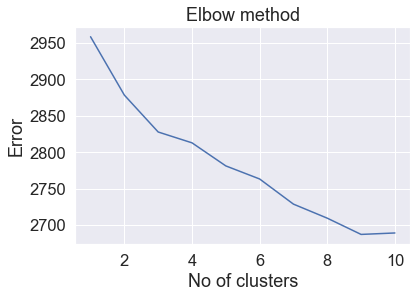

In [141]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

**Now, let's insert the cluster number to each of the cities in the dataframe**

In [142]:
cities_sortedVenues.insert(0, 'Cluster Labels', k_mod.labels_)

**Map the clusters**

In [143]:
# create map
map_clusters = folium.Map(location=[37.0902,-95.7129], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_sortedVenues['Latitude'], cities_sortedVenues['Longitude'], cities_sortedVenues['City'], cities_sortedVenues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine the Clusters

**Cluster 0**

In [144]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 0, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,"McKinney, TX",35.0,87608.0,5.230,82370.0,5.4800,255300.0,11.70,64953.0,45959.0,1.413281,0.482,0.0,1064.0,14.70,91.2,3407.0,0.686634,0.020679,56400.0,2.921277,66.6,26.7,McKinney,Texas,163.2,1056,TX,33.1985,-96.6680,Coffee Shop,Grocery Store,Fast Food Restaurant,Supermarket,Park,Mexican Restaurant,Convenience Store,Burger Joint,American Restaurant,Ice Cream Shop
89,"Pasadena, TX",31.3,50207.0,3.290,66038.0,0.0394,108700.0,4.02,64953.0,45959.0,1.413281,0.482,0.0,1749.0,25.90,82.1,10301.0,0.888013,0.066929,48900.0,3.147423,53.3,25.5,Pasadena,Texas,112.7,1361,TX,29.6586,-95.1506,Mexican Restaurant,Pizza Place,Coffee Shop,Burger Joint,Cosmetics Shop,Fast Food Restaurant,Grocery Store,Spa,Gas Station,Pharmacy
98,"Sugar Land, TX",41.6,108994.0,0.452,41907.0,0.4460,292700.0,3.28,64953.0,45959.0,1.413281,0.482,0.0,1245.0,35.10,87.8,0.0,1.000000,NaN,28900.0,3.006436,80.7,28.6,Sugar Land,Texas,88.1,1347,TX,29.5994,-95.6142,Grocery Store,Park,Fast Food Restaurant,Mexican Restaurant,Burger Joint,Coffee Shop,American Restaurant,Fried Chicken Joint,Liquor Store,Supermarket
102,"League City, TX",34.6,100996.0,4.030,50908.0,1.7300,218900.0,8.37,64953.0,45959.0,1.413281,0.482,0.0,1395.0,8.94,96.3,0.0,1.000000,NaN,34500.0,2.846812,72.7,29.3,League City,Texas,132.6,769,TX,29.4901,-95.1091,Mexican Restaurant,Park,Coffee Shop,BBQ Joint,Supermarket,Pizza Place,Grocery Store,American Restaurant,Pharmacy,Bakery
103,"Allen, TX",36.2,104132.0,1.880,50313.0,2.2100,261600.0,11.50,64953.0,45959.0,1.413281,0.482,0.0,1064.0,19.30,92.0,0.0,1.000000,NaN,31600.0,3.065348,76.2,25.6,Allen,Texas,70.2,1434,TX,33.0997,-96.6631,Fast Food Restaurant,Burger Joint,Coffee Shop,Mexican Restaurant,Pizza Place,Grocery Store,Ice Cream Shop,Movie Theater,American Restaurant,Salon / Barbershop
193,"Independence, MO",40.6,46268.0,4.170,53964.0,1.3600,102800.0,2.29,59788.0,43527.0,1.373584,0.462,0.0,1305.0,4.98,97.1,65.0,0.160714,0.000554,48200.0,2.435041,61.1,24.0,Independence,Missouri,201.5,581,MO,39.0855,-94.3521,Convenience Store,Sporting Goods Shop,Fast Food Restaurant,American Restaurant,Coffee Shop,Burger Joint,Mexican Restaurant,Chinese Restaurant,Sandwich Place,Bookstore


In [145]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 1, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,"Joliet, IL",33.5,63359.0,2.4700,71677.0,1.31000,165600.0,1.0400,71579.0,52403.0,1.365933,0.483,0.415800,1799.0,14.00,92.0,4537.0,0.696075,0.030620,47600.0,3.112857,70.7,29.7,Joliet,Illinois,166.8,889,IL,41.517700,-88.148800,Pizza Place,Ice Cream Shop,Sandwich Place,American Restaurant,Gym / Fitness Center,Hot Dog Joint,Fast Food Restaurant,Grocery Store,Mexican Restaurant,Donut Shop
83,"Garland, TX",34.5,55637.0,4.5400,114112.0,0.91600,132600.0,9.2300,64953.0,45959.0,1.413281,0.482,0.000000,1476.0,28.20,82.8,923.0,0.417819,0.003912,75800.0,3.112995,61.9,27.6,Garland,Texas,147.6,1592,TX,32.909800,-96.630300,Mexican Restaurant,Coffee Shop,Fast Food Restaurant,Seafood Restaurant,Grocery Store,Italian Restaurant,Convenience Store,Nail Salon,Brewery,Gym / Fitness Center
85,"Grand Prairie, TX",32.9,62589.0,3.8900,94487.0,2.50000,139600.0,5.2800,64953.0,45959.0,1.413281,0.482,0.000000,1476.0,21.60,87.4,1563.0,0.892252,0.008285,60100.0,3.139168,62.7,27.8,Grand Prairie,Texas,187.3,1018,TX,32.686900,-97.021100,Coffee Shop,Fast Food Restaurant,Restaurant,Convenience Store,Mexican Restaurant,Furniture / Home Store,Chinese Restaurant,Clothing Store,Pharmacy,American Restaurant
87,"Frisco, TX",36.5,120701.0,2.6000,77646.0,6.88000,335900.0,11.6000,64953.0,45959.0,1.413281,0.482,0.000000,1064.0,19.80,90.4,8.0,0.000000,0.000051,52300.0,2.970612,74.0,26.7,Frisco,Texas,175.3,933,TX,33.155400,-96.822600,Ice Cream Shop,Coffee Shop,Fast Food Restaurant,Mexican Restaurant,Italian Restaurant,Gym / Fitness Center,Grocery Store,Burger Joint,Sushi Restaurant,BBQ Joint
88,"Brownsville, TX",30.3,35636.0,4.0300,68045.0,1.70000,85900.0,2.5100,64953.0,45959.0,1.413281,0.482,0.000000,2199.0,29.50,80.6,1297.0,0.545888,0.007123,51100.0,3.563268,62.4,19.6,Brownsville,Texas,343.2,536,TX,25.999100,-97.455000,Mexican Restaurant,Burger Joint,Pizza Place,Pharmacy,Department Store,Seafood Restaurant,Big Box Store,Wings Joint,Hardware Store,Food Service
90,"Killeen, TX",28.2,48898.0,1.5400,55438.0,5.76000,121900.0,2.9600,64953.0,45959.0,1.413281,0.482,0.000000,1250.0,9.44,96.3,748.0,0.578059,0.005323,50100.0,2.804651,45.1,20.7,Killeen,Texas,138.6,1030,TX,31.077700,-97.732000,Coffee Shop,Burger Joint,Grocery Store,Fast Food Restaurant,Park,Sandwich Place,American Restaurant,Mexican Restaurant,Vietnamese Restaurant,Diner
93,"Denton, TX",29.1,52164.0,3.3200,67369.0,3.11000,179000.0,10.0000,64953.0,45959.0,1.413281,0.482,0.000000,1564.0,13.30,90.7,13201.0,0.501649,0.100696,45900.0,2.856144,47.8,22.7,Denton,Texas,241.9,553,TX,33.216600,-97.141400,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,Burger Joint,Pizza Place,Supermarket,Breakfast Spot,Ice Cream Shop,Grocery Store,Fried Chicken Joint
95,"Round Rock, TX",33.9,76295.0,2.9800,60906.0,4.35000,210800.0,9.5100,64953.0,45959.0,1.413281,0.482,0.000000,1509.0,13.90,92.4,261.0,0.977273,0.002243,37300.0,3.119812,62.4,23.4,Round Rock,Texas,92.2,1311,TX,30.525200,-97.666000,American Restaurant,Coffee Shop,Grocery Store,Mexican Restaurant,Burger Joint,Pizza Place,Fast Food Restaurant,Gym,BBQ Joint,Sandwich Place
100,"College Station, TX",22.7,39430.0,8.1100,52351.0,4.42000,205600.0,6.6900,64953.0,45959.0,1.413281,0.482,0.000000,1162.0,12.80,90.8,16443.0,0.980607,0.153036,38700.0,2.776357,35.5,

In [146]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 2, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"San Jose, CA",37.0,113036.0,7.990,544945.0,0.219,968500.0,13.30,78575.0,62298.0,1.261276,0.499,0.402414,973.0,39.0,83.1,12445.0,0.783718,0.012083,328000.0,3.140244,55.3,29.7,San Jose,California,459.7,2231,CA,37.2967,-121.8189,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Vietnamese Restaurant,Park,Ice Cream Shop,Coffee Shop,Frozen Yogurt Shop,Breakfast Spot
11,"Anaheim, CA",34.4,76154.0,8.180,180144.0,2.320,606600.0,5.04,78575.0,62298.0,1.261276,0.499,0.402414,1053.0,36.4,81.6,2895.0,0.860540,0.008224,102000.0,3.451157,48.4,27.8,Anaheim,California,129.5,2711,CA,33.8555,-117.7601,Grocery Store,Park,Coffee Shop,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Burger Joint,Gym / Fitness Center,Seafood Restaurant,Pizza Place
13,"Riverside, CA",31.2,67850.0,1.380,156254.0,1.680,385000.0,4.45,78575.0,62298.0,1.261276,0.499,0.402414,2380.0,22.2,90.4,13042.0,0.684143,0.039512,87300.0,3.780985,55.0,28.9,Riverside,California,210.3,1544,CA,33.9381,-117.3932,Coffee Shop,Mexican Restaurant,Park,Grocery Store,Fast Food Restaurant,Italian Restaurant,Sandwich Place,American Restaurant,Pizza Place,Golf Course
14,"Stockton, CA",32.8,54297.0,5.770,128717.0,-1.500,299800.0,6.31,78575.0,62298.0,1.261276,0.499,0.402414,1697.0,25.7,86.8,7346.0,0.615215,0.023606,95600.0,3.255115,44.1,33.7,Stockton,California,159.8,1922,CA,37.9763,-121.3133,Coffee Shop,Mexican Restaurant,Pizza Place,Chinese Restaurant,Pharmacy,Grocery Store,Park,Fast Food Restaurant,American Restaurant,Ice Cream Shop
16,"Chula Vista, CA",34.6,86082.0,11.400,126543.0,6.400,532700.0,7.01,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,30.8,87.7,3670.0,0.523454,0.013510,78100.0,3.478271,58.2,29.7,Chula Vista,California,128.5,2080,CA,32.6277,-117.0152,Grocery Store,Mexican Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Taco Place,Pharmacy,Fast Food Restaurant,Cosmetics Shop,Park
17,"Fremont, CA",37.7,122191.0,9.480,116110.0,2.750,785700.0,11.80,72235.0,57252.0,1.261703,0.500,0.000000,953.0,47.5,78.7,2395.0,0.545161,0.010370,73600.0,3.138098,62.4,31.7,Fremont,California,200.7,1161,CA,37.4945,-121.9412,Gym,Fast Food Restaurant,Bakery,Ice Cream Shop,Trail,Sandwich Place,Coffee Shop,Grocery Store,Park,Mediterranean Restaurant
18,"San Bernardino, CA",29.4,41027.0,6.690,78721.0,2.600,202100.0,14.30,72235.0,57252.0,1.261703,0.500,0.000000,1752.0,23.6,85.0,7307.0,0.607347,0.033946,58000.0,3.711241,46.8,26.7,San Bernardino,California,159.3,1358,CA,34.1416,-117.2936,Mexican Restaurant,Fast Food Restaurant,Burger Joint,Coffee Shop,American Restaurant,Pizza Place,Breakfast Spot,Ice Cream Shop,Sports Bar,Chinese Restaurant
19,"Fontana, CA",30.6,68304.0,3.500,92883.0,3.790,323300.0,11.70,72235.0,57252.0,1.261703,0.500,0.000000,1752.0,27.4,85.7,32.0,0.032258,0.000155,51900.0,3.990096,64.4,31.5,Fontana,California,111.4,1883,CA,34.1090,-117.4629,Fast Food Restaurant,American Restaurant,Coffee Shop,Grocery Store,Shopping Mall,Movie Theater,Hardware Store,Bakery,Mexican Restaurant,Sushi Restaurant
20,"Santa Clarita, CA",36.9,90544.0,6.470,103529.0,16.700,461500.0,10.60,72235.0,57252.0,1.261703,0.500,0.000000,1391.0,20.9,91.5,4797.0,0.852124,0.022899,67900.0,3.085258,67.7,32.6,Santa Clarita,California,136.8,1331,CA,34.4030,-118.5042,Coffee Shop,Groce

In [147]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 3, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Yonkers, NY",38.8,62399.0,1.840,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,Yonkers,New York,46.6,4307,NY,40.9459,-73.8674,Pizza Place,Italian Restaurant,Grocery Store,Bar,Bakery,Trail,Park,Sushi Restaurant,Ice Cream Shop,Coffee Shop
3,"Los Angeles, CA",35.8,62474.0,3.780,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,Los Angeles,California,1213.9,3276,CA,34.0194,-118.4108,Coffee Shop,Ice Cream Shop,Grocery Store,Hotel,American Restaurant,Sushi Restaurant,New American Restaurant,Café,Boutique,Bakery
4,"San Diego, CA",35.4,79646.0,3.890,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,San Diego,California,842.3,1670,CA,32.8153,-117.1350,Coffee Shop,Grocery Store,Sandwich Place,Brewery,Japanese Restaurant,Pizza Place,Bakery,Seafood Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
6,"San Francisco, CA",38.3,112376.0,1.410,536653.0,0.392,1200000.0,8.300,78575.0,62298.0,1.261276,0.499,0.402414,631.0,34.00,87.6,20817.0,0.640684,0.023567,363000.0,2.433347,37.6,30.9,San Francisco,California,121.5,7170,CA,37.7272,-123.0322,Outdoors & Recreation,Zoo Exhibit,Flower Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service
8,"Long Beach, CA",35.8,61610.0,1.740,238174.0,3.010,600700.0,7.710,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,26.00,88.5,13702.0,0.745033,0.029318,173000.0,2.701462,40.8,29.4,Long Beach,California,130.3,3609,CA,33.8092,-118.1553,Coffee Shop,Mexican Restaurant,Fast Food Restaurant,Park,Grocery Store,Brewery,Thai Restaurant,American Restaurant,Diner,Café
9,"Oakland, CA",36.8,76469.0,8.350,235825.0,4.830,717700.0,4.510,78575.0,62298.0,1.261276,0.499,0.402414,953.0,27.10,87.5,4001.0,0.423843,0.009324,166000.0,2.585024,41.3,31.1,Oakland,California,144.8,2901,CA,37.7698,-122.2257,Coffee Shop,Bakery,Grocery Store,Brewery,Café,Thai Restaurant,Beer Garden,Pizza Place,Park,Mexican Restaurant
12,"Santa Ana, CA",32.0,65313.0,-0.521,164903.0,-3.020,534600.0,8.070,78575.0,62298.0,1.261276,0.499,0.402414,1053.0,45.30,76.3,5746.0,0.686033,0.017269,78800.0,4.222424,44.8,24.8,Santa Ana,California,70.2,4762,CA,33.7363,-117.8830,Sandwich Place,Fast Food Restaurant,Bakery,Coffee Shop,Grocery Store,Shopping Mall,Japanese Restaurant,Asian Restaurant,Supermarket,Gym / Fitness Center
15,"Irvine, CA",34.4,95573.0,1.870,124407.0,3.580,753400.0,4.810,72235.0,57252.0,1.261703,0.500,0.000000,1053.0,39.60,81.7,18053.0,0.764884,0.070279,92900.0,2.765091,48.2,23.3,Irvine,California,169.9,1566,CA,33.6784,-117.7713,Grocery Store,Park,Sandwich Place,Burger Joint,Coffee Shop,Fast Food Restaurant,Frozen Yogurt Shop,Trail,Dessert Shop,Candy Store
21,"Oxnard, CA",31.7,64837.0,5.070,97316.0,2.380,390000.0,7.470,72235.0,57252.0,1.261703,0.500,0.000000,1303.0,36.10,77.8,1620.0,0.732620,0.007836,51100.0,4.045636,53.3,25.0,Oxnard,California,69.7,2984,CA,34.2023,-119.2046,Beach,Seafood Restaurant,Pizza Place,Burger Joint,Coffee Shop,Mexican Restaurant,Grocery Stor

In [90]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 4, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New York, NY",36.9,63799.0,4.800,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,New York,New York,780.9,10933,NY,40.6635,-73.9387,Pizza Place,Brewery,Bar,Italian Restaurant,Ice Cream Shop,Gourmet Shop,Coffee Shop,Bookstore,Park,Field
1,"Buffalo, NY",33.3,37359.0,7.310,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,Buffalo,New York,104.6,2455,NY,42.8925,-78.8597,Bar,New American Restaurant,American Restaurant,Brewery,Coffee Shop,Food Truck,Taco Place,Pizza Place,Grocery Store,Park
7,"Sacramento, CA",34.3,65046.0,14.200,239523.0,2.480,358300.0,6.670,78575.0,62298.0,1.261276,0.499,0.402414,1227.0,22.10,89.8,12549.0,0.779495,0.024678,183000.0,2.778781,49.1,24.8,Sacramento,California,253.6,1953,CA,38.5666,-121.4686,Coffee Shop,Park,Grocery Store,American Restaurant,Bakery,New American Restaurant,Pizza Place,Hotel,Breakfast Spot,Steakhouse
72,"Chicago, IL",34.9,57238.0,3.510,1370000.0,1.270,271600.0,6.140,74413.0,55889.0,1.331443,0.480,-0.414938,1062.0,20.80,89.7,61544.0,0.737304,0.022710,1080000.0,2.509259,45.7,33.5,Chicago,Illinois,588.7,4600,IL,41.8376,-87.6818,Coffee Shop,New American Restaurant,Park,Grocery Store,Deli / Bodega,Brewery,Sandwich Place,Hotel,Liquor Store,Restaurant
77,"San Antonio, TX",33.7,49024.0,-2.040,716405.0,1.420,155600.0,4.990,67436.0,48835.0,1.380895,0.479,0.000000,1370.0,13.70,90.9,32538.0,0.744758,0.021267,510000.0,3.000000,53.0,23.8,San Antonio,Texas,1194,1250,TX,29.4724,-98.5251,Coffee Shop,Burger Joint,Mexican Restaurant,Grocery Store,Park,Pizza Place,Bakery,Hotel,Bar,American Restaurant
78,"Dallas, TX",33.3,52210.0,3.130,681537.0,0.174,209700.0,10.000,67436.0,48835.0,1.380895,0.479,0.000000,1476.0,23.70,81.6,12208.0,0.574819,0.009043,521000.0,2.591171,40.2,25.8,Dallas,Texas,882.9,1493,TX,32.7933,-96.7665,Coffee Shop,Pizza Place,Park,Grocery Store,Seafood Restaurant,Burger Joint,Brewery,Mexican Restaurant,Trail,Taco Place
79,"Austin, TX",33.6,71543.0,5.590,564744.0,2.480,365500.0,9.860,67436.0,48835.0,1.380895,0.479,0.000000,1181.0,17.70,87.5,25278.0,0.780768,0.026215,390000.0,2.472418,44.8,22.0,Austin,Texas,809.9,1170,TX,30.3039,-97.7544,Park,Coffee Shop,Grocery Store,Pizza Place,Taco Place,Ice Cream Shop,Hotel,Pool,Sandwich Place,Trail
113,"Philadelphia, PA",34.5,46116.0,16.000,714190.0,6.010,167700.0,0.903,69779.0,52119.0,1.338840,0.469,-0.635593,1458.0,13.30,92.8,41499.0,0.736869,0.026265,608000.0,2.598684,52.7,33.0,Philadelphia,Pennsylvania,347.6,4511,PA,40.0094,-75.1333,Park,Coffee Shop,Trail,Brewery,Art Museum,Sandwich Place,Pizza Place,Café,Bar,Ice Cream Shop
115,"Miami, FL",40.5,41818.0,3.700,235956.0,5.030,350400.0,8.790,62257.0,46612.0,1.335643,0.474,0.211416,1246.0,55.40,71.8,14656.0,0.700824,0.031123,183000.0,2.573284,30.6,28.5,Miami,Florida,93.2,4865,FL,25.7752,-80.2086,Hotel,Park,Coffee Shop,Asian Restaurant,Seafood Restaurant,Bar,Residential Building (Apartment / Condo),Sandwich Place,Dog Run,Brewery
116,"Tampa, FL",34.6,54599.0,8.140,191406.0,-0.721,257600.0,10.200,62257.0,46612.0,1.335643,0.474,0.211416,1189.0,15.50,91.5,30419.0,0.477798,0.077421,154000.0,2.5513

In [91]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 5, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
163,"Lowell, MA",33.3,48581.0,3.43,53075.0,0.809,240500.0,2.730,84043.0,62850.0,1.337200,0.485,0.000000,788.0,27.10,87.0,4527.0,1.290992,0.040797,39000.0,2.845231,42.2,25.0,Lowell,Massachusetts,35.2,3139,MA,42.6390,-71.3211,Pizza Place,Pharmacy,Donut Shop,American Restaurant,Asian Restaurant,Mexican Restaurant,Bar,Ice Cream Shop,Liquor Store,Supermarket
164,"Detroit, MI",35.0,31283.0,3.09,249478.0,6.570,51600.0,2.790,66961.0,48599.0,1.377827,0.472,-0.211416,1470.0,5.81,95.2,11564.0,0.685960,0.017191,266000.0,2.528876,46.8,24.9,Detroit,Michigan,359.5,1871,MI,42.3830,-83.1022,Bakery,Deli / Bodega,Bar,Coffee Shop,Art Gallery,Farmers Market,American Restaurant,Burger Joint,History Museum,Pizza Place
207,"Newark, NJ",33.7,37642.0,7.04,128606.0,8.870,251800.0,7.150,89489.0,65578.0,1.364619,0.493,0.000000,1217.0,29.20,82.1,7366.0,1.341386,0.026111,102000.0,2.765706,21.9,33.1,Newark,New Jersey,62.4,4514,NJ,40.7242,-74.1726,Park,Pizza Place,Clothing Store,Italian Restaurant,Bakery,Café,Liquor Store,Vietnamese Restaurant,Bagel Shop,Coffee Shop
209,"Paterson, NJ",33.1,36106.0,6.06,60972.0,3.910,235500.0,-0.212,84632.0,61412.0,1.378102,0.493,0.407332,1686.0,36.70,81.0,1344.0,0.816216,0.009088,43800.0,3.376484,26.9,23.4,Paterson,New Jersey,21.8,6800,NJ,40.9148,-74.1628,Pizza Place,Ice Cream Shop,Park,Hot Dog Joint,Italian Restaurant,Middle Eastern Restaurant,Convenience Store,Spanish Restaurant,Sushi Restaurant,Grocery Store
210,"Elizabeth, NJ",33.9,45186.0,3.09,62351.0,2.840,268700.0,2.440,84632.0,61412.0,1.378102,0.493,0.407332,1502.0,46.90,72.9,0.0,1.000000,NaN,40200.0,3.217985,24.7,25.7,Elizabeth,New Jersey,31.9,4038,NJ,40.6664,-74.1935,Pizza Place,Clothing Store,Ice Cream Shop,Park,Bakery,Spanish Restaurant,Portuguese Restaurant,Liquor Store,Café,BBQ Joint
225,"Hartford, CT",30.9,33841.0,5.44,50433.0,2.120,162300.0,2.010,89173.0,62104.0,1.435866,0.504,-0.198020,1056.0,21.80,87.1,3258.0,0.751613,0.026192,45800.0,2.715939,23.8,22.1,Hartford,Connecticut,45.1,2735,CT,41.7659,-72.6816,American Restaurant,Bakery,Caribbean Restaurant,Italian Restaurant,Pizza Place,Pub,Park,Theater,Brewery,Vietnamese Restaurant


In [92]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 6, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Bakersfield, CA",31.6,60002.0,5.070,166626.0,6.740,257200.0,7.300,78575.0,62298.0,1.261276,0.499,0.402414,2037.0,18.30,90.8,5643.0,0.512463,0.014711,122000.0,3.144270,59.2,21.8,Bakersfield,California,385.4,976,CA,35.3212,-119.0183,Mexican Restaurant,Pizza Place,Burger Joint,Coffee Shop,Thai Restaurant,Grocery Store,Sandwich Place,Bar,Bakery,Italian Restaurant
76,"Elgin, IL",34.1,63655.0,5.430,55424.0,2.110,171200.0,2.820,71579.0,52403.0,1.365933,0.483,0.415800,2380.0,26.50,84.3,2565.0,0.941711,0.022774,35900.0,3.137270,66.9,27.5,Elgin,Illinois,96.9,1158,IL,42.0396,-88.3217,Breakfast Spot,Ice Cream Shop,Pizza Place,Coffee Shop,American Restaurant,Sushi Restaurant,Chinese Restaurant,Golf Course,Mexican Restaurant,Donut Shop
81,"Arlington, TX",33.1,63091.0,10.500,211698.0,7.550,188800.0,12.500,67436.0,48835.0,1.380895,0.479,0.000000,1758.0,20.60,89.5,13905.0,0.566408,0.034926,136000.0,2.927368,54.6,25.9,Arlington,Texas,248.1,1600,TX,32.7007,-97.1247,Coffee Shop,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Bar,Vietnamese Restaurant,Sandwich Place,Park,Chinese Restaurant,Pizza Place
91,"McAllen, TX",32.9,45057.0,-1.120,58587.0,1.590,120500.0,2.550,64953.0,45959.0,1.413281,0.482,0.000000,2228.0,27.40,82.8,7040.0,0.628876,0.050344,44000.0,3.178136,59.6,19.1,McAllen,Texas,151.3,940,TX,26.2322,-98.2464,Mexican Restaurant,Grocery Store,Burger Joint,Big Box Store,Coffee Shop,Bakery,Fast Food Restaurant,Park,Breakfast Spot,Ice Cream Shop
92,"Mesquite, TX",32.8,52167.0,2.680,69482.0,-0.023,119000.0,5.870,64953.0,45959.0,1.413281,0.482,0.000000,1476.0,18.60,87.5,1785.0,0.760355,0.012386,46900.0,3.072878,57.7,30.6,Mesquite,Texas,122.2,1176,TX,32.7629,-96.5888,Mexican Restaurant,Convenience Store,Burger Joint,BBQ Joint,Fast Food Restaurant,Pizza Place,Grocery Store,Steakhouse,Park,American Restaurant
96,"Pearland, TX",35.1,102124.0,5.330,58994.0,7.550,208900.0,7.570,64953.0,45959.0,1.413281,0.482,0.000000,1532.0,15.90,94.7,0.0,1.000000,NaN,38800.0,2.930232,75.9,32.4,Pearland,Texas,119.9,947,TX,29.5558,-95.3231,Burger Joint,Fast Food Restaurant,Grocery Store,Donut Shop,Supermarket,Sporting Goods Shop,Coffee Shop,Mexican Restaurant,Pharmacy,Park
99,"Beaumont, TX",34.3,45268.0,6.780,52496.0,1.820,99800.0,0.000,64953.0,45959.0,1.413281,0.482,0.000000,1684.0,10.40,92.8,5734.0,0.630367,0.048419,46200.0,2.563290,56.3,18.2,Beaumont,Texas,212.6,556,TX,30.0849,-94.1453,Mexican Restaurant,Bakery,Burger Joint,Deli / Bodega,Pizza Place,Sandwich Place,Grocery Store,Gym,Italian Restaurant,Seafood Restaurant
105,"Mesa, AZ",35.8,58247.0,5.880,241819.0,2.250,242500.0,7.920,62316.0,49405.0,1.261330,0.460,-1.918977,1411.0,11.70,91.8,6951.0,0.788729,0.013657,186000.0,2.736446,60.0,23.3,Mesa,Arizona,357.2,1357,AZ,33.4019,-111.7174,Pizza Place,Grocery Store,Coffee Shop,Sandwich Place,Italian Restaurant,Convenience Store,Restaurant,Mexican Restaurant,Bakery,American Restaurant
119,"Hialeah, FL",44.2,31012.0,4.010,105678.0,1.950,174300.0,6.540,58931.0,44078.0,1.336971,0.473,0.424628,1246.0,74.40,65.1,2501.0,0.435706,0.010530,71700.0,3.312734,45.5,23.4,Hialeah,Florida,55.7,4245,FL,25.8699,-80.3029,Coffee Shop,Mexican Restaurant,Grocery Store,Cuban Restaurant,Pharmacy,Sandwich Place,Park,Pizza Place,Italian Restaurant,Ware

In [93]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 7, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
156,"Arvada, CO",40.1,75640.0,5.04,62707.0,2.240,312500.0,12.40,68531.0,51692.0,1.325756,0.471,0.000000,1237.0,5.25,97.7,90.0,0.000000,0.000780,46000.0,2.506957,73.4,25.4,Arvada,Colorado,100,1175,CO,39.8337,-105.1503,Grocery Store,Coffee Shop,Mexican Restaurant,Brewery,Dog Run,Bar,Fast Food Restaurant,Japanese Restaurant,Bakery,Liquor Store
182,"Reno, NV",35.5,52106.0,6.74,120384.0,3.100,265600.0,12.60,57432.0,44567.0,1.288667,0.444,0.680272,1397.0,16.50,91.2,7359.0,0.710202,0.030697,96400.0,2.486846,47.5,18.7,Reno,Nevada,277.9,883,NV,39.5491,-119.8499,Mexican Restaurant,Coffee Shop,Breakfast Spot,Pizza Place,Pub,Bar,American Restaurant,Brewery,Café,Steakhouse
184,"Sparks, NV",37.8,58120.0,7.24,48084.0,5.810,244000.0,16.90,57432.0,44567.0,1.288667,0.444,0.680272,1397.0,15.00,92.9,461.0,0.436137,0.004763,37000.0,2.615838,57.0,21.1,Sparks,Nevada,93,1080,NV,39.5544,-119.7356,Coffee Shop,Breakfast Spot,Brewery,American Restaurant,Park,Mexican Restaurant,Cocktail Bar,Café,Pizza Place,Deli / Bodega
237,"Rochester, NY",40.5,60190.0,5.65,518484.0,-2.270,148000.0,2.42,81735.0,63914.0,1.278828,0.493,-0.804829,1202.0,6.97,96.9,19930.0,0.784883,0.018626,431000.0,2.482599,68.2,20.6,Rochester,New York,92.7,2253,NY,43.1699,-77.6169,Coffee Shop,Bakery,Park,Deli / Bodega,Pizza Place,Brewery,Museum,Pub,Italian Restaurant,Diner
246,"Dayton, OH",39.4,54942.0,4.17,382534.0,2.310,143600.0,7.65,65155.0,48520.0,1.342848,0.460,0.656455,1307.0,4.33,98.1,16739.0,0.871743,0.020754,331000.0,2.436701,61.9,20.7,Dayton,Ohio,144.3,974,OH,39.7774,-84.1996,Park,Pizza Place,American Restaurant,Brewery,Bar,Mexican Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Burger Joint
250,"Syracuse, NY",39.7,58715.0,3.41,307528.0,-0.391,140000.0,0.43,81735.0,63914.0,1.278828,0.493,-0.804829,1202.0,6.02,97.1,16043.0,0.784340,0.024662,257000.0,2.531136,68.1,19.9,Syracuse,New York,64.7,2214,NY,43.0410,-76.1436,Pizza Place,Coffee Shop,Supermarket,Breakfast Spot,Bakery,Grocery Store,Pub,American Restaurant,Plaza,Donut Shop


### Recommendation System
___
There are different types of basic recommendations systems available. The most common are:
1. Content-based recomenndation
2. Collaborative Filtering
3. Hybrid of Content and Collaborative

Since we do not have information about users, we will create a **content-based** recommendation system that leverages the user's input to weight the variables based on their rating of cities they like.

###### First, lets create a class for a rated city

In [94]:
class rated_city:
    def __init__(self, city, rating):
        self.city = city
        self.rating = rating

##### Second, create a function that takes in the cities the user liked and wants to rate
**Note that city names MUST include the state abbreviation**

    Example: New York, NY 
             Boston, MA

In [95]:
def input_cities():
    add_city = True
    userInput = []
    while add_city == True:
        city_name = input("City (Include state - Ex. Boston, MA): ")
        rating = input("What rating yould you give the city (1-10): ")
        city = rated_city(city_name, rating)
        userInput.append(city.__dict__)
        cont = input("Do you want to rate another city?")
        add_city = cont.lower() in ['yes','true','of course','y','si','1']
    
    inputMovies = pd.DataFrame(userInput)
        
    return(inputMovies)

In [99]:
inputCities = input_cities()

City (Include state - Ex. Boston, MA): Boston, MA
What rating yould you give the city (1-10): 10
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): New York, NY
What rating yould you give the city (1-10): 8
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Seattle, WA
What rating yould you give the city (1-10): 9
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): San Francisco, CA
What rating yould you give the city (1-10): 8
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Philadelphia, PA
What rating yould you give the city (1-10): 5
Do you want to rate another city?n


In [100]:
inputCities

,city,rating
0,"Boston, MA",10
1,"New York, NY",8
2,"Seattle, WA",9
3,"San Francisco, CA",8
4,"Philadelphia, PA",5


Before we begin learning the preferences based on the input, let's input city names into the normalized (scaled) data.

In [101]:
norm_df = pd.DataFrame(X)
norm_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,1.000000,0.000000,0.462555,0.637255,0.366942,0.500891,1.000000,0.119646,0.516806,0.525487,0.580772,0.577134,0.160253,0.849315,0.394921,0.305298,0.485456,0.553314,1.000000,0.088027,0.054076,1.000000,0.168355,0.181667,0.882353,0.173566,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.00,0.166667,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.181818,0.0,0.714286,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.666667,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.333333,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.50,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,1.00,0.0,0.00,0.000000,0.0,0.0,0.000000,0.25,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.500,0.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.4,0.285714,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.538462,0.0,0.333333,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.4,0.0,0.5,0.083333,0.0,0.0,0.0,0.0,0.00

In [102]:
names_norm = list(usa_cluster_predictors.columns)

In [106]:
names_norm_dict = {}
for i in range(0,len(names_norm)):
    names_norm_dict[i]=names_norm[i]

In [107]:
norm_df=norm_df.rename(columns=names_norm_dict)
norm_df.head()

,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,Land_Area_km2,Population_Density_per_km2,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hunan Restaurant,Hunting Suppl

In [108]:
norm_df.insert(0, 'City', cities_one_hot.City)
norm_df.insert(0, 'Cluster Labels', k_mod.labels_)
norm_df.head()

,Cluster Labels,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,Land_Area_km2,Population_Density_per_km2,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hunan Rest

In [109]:
#Get the dummy variables for each cluster
recom_dummies = pd.get_dummies(norm_df[['Cluster Labels']].astype(str), prefix="", prefix_sep="")

#Add name of city to dataframe
recom_dummies['City'] = norm_df['City']

#Lets make it readable by changing the location of the City column to be the first column of the dataframe
move_column = [recom_dummies.columns[-1]] + list(recom_dummies.columns[:-1])
recom_dummies = recom_dummies[move_column]

print(recom_dummies.shape)
recom_dummies.head()
recom_dummies = recom_dummies.rename(columns={'0':'Cluster 0','1':'Cluster 1','2':'Cluster 2','3':'Cluster 3','4':'Cluster 4','5':'Cluster 5','6':'Cluster 6','7':'Cluster 7'})

(299, 9)


In [110]:
norm_df = norm_df.merge(recom_dummies, on='City')

Above, we added the cities and cluster labels to the normalized dataframe.

Now we can begin learning the preferences based on the input.

In [111]:
userCities = norm_df[norm_df['City'].isin(inputCities['city'].tolist())]

userCities = userCities.reset_index(drop=True)
cityCluster_df = userCities[['Cluster Labels','City']]
userCities = userCities.drop('Cluster Labels',1).drop('City',1)

In [112]:
userProfile = userCities.transpose().dot(inputCities['rating'].astype(float))

In [113]:
prerecommend_df = norm_df.drop('Cluster Labels',1).drop('City',1)

In [114]:
recommendation_df = ((prerecommend_df*userProfile).sum(axis=1))/userProfile.sum()
recommendation_df = recommendation_df.sort_values(ascending=False)
recommendation_df.head(10)

0      0.462771
143    0.344138
113    0.333141
160    0.288096
208    0.268654
3      0.264837
162    0.252372
72     0.250019
50     0.245399
231    0.244169
dtype: float64

In [116]:
def top_X(num):
    newdf = pd.DataFrame(recommendation_df.head(num))
    indexValues = newdf.index.values
    listindex = list(indexValues)
    resultCities = cities_sortedVenues.reindex(listindex).reset_index()
    return(resultCities)
top_X(20)

,index,Cluster Labels,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,4,"New York, NY",8400000.0,-2.600,19.60,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,New York,New York,780.9,10933,NY,40.6635,-73.9387,Pizza Place,Brewery,Bar,Italian Restaurant,Ice Cream Shop,Gourmet Shop,Coffee Shop,Bookstore,Park,Field
1,143,4,"Seattle, WA",744949.0,2.790,12.50,35.2,93481.0,7.67,451954.0,3.770,758200.0,12.600,79555.0,58794.0,1.353114,0.469,0.643777,843.0,17.10,89.7,24036.0,0.770738,0.032265,338000.0,2.203991,44.7,26.2,Seattle,Washington,217,3245,WA,47.6205,-122.3509,Park,Coffee Shop,Bakery,Yoga Studio,Museum,Sandwich Place,Donut Shop,Cocktail Bar,Fish Market,Brewery
2,113,4,"Philadelphia, PA",1580000.0,0.207,25.80,34.5,46116.0,16.00,714190.0,6.010,167700.0,0.903,69779.0,52119.0,1.338840,0.469,-0.635593,1458.0,13.30,92.8,41499.0,0.736869,0.026265,608000.0,2.598684,52.7,33.0,Philadelphia,Pennsylvania,347.6,4511,PA,40.0094,-75.1333,Park,Coffee Shop,Trail,Brewery,Art Museum,Sandwich Place,Pizza Place,Café,Bar,Ice Cream Shop
3,160,4,"Boston, MA",695926.0,1.890,20.50,32.1,71834.0,7.60,382784.0,0.310,575200.0,6.400,89637.0,66042.0,1.357273,0.483,-0.206612,667.0,27.80,86.4,42430.0,0.664313,0.060969,275000.0,2.530640,34.1,30.0,Boston,Massachusetts,125.1,5381,MA,42.3320,-71.0202,Park,Italian Restaurant,Bakery,Gourmet Shop,American Restaurant,Hotel,French Restaurant,Mexican Restaurant,Seafood Restaurant,Bar
4,208,3,"Jersey City, NJ",265560.0,-1.920,18.70,34.2,72561.0,9.50,141780.0,1.060,416900.0,9.740,89489.0,65578.0,1.364619,0.493,0.000000,1923.0,41.00,77.6,4172.0,0.527086,0.015710,102000.0,2.603529,29.6,37.0,Jersey City,New Jersey,38.3,6891,NJ,40.7114,-74.0648,Park,Bakery,Scenic Lookout,Ice Cream Shop,Bookstore,Italian Restaurant,Pizza Place,Memorial Site,Gourmet Shop,Hotel
5,3,3,"Los Angeles, CA",3990000.0,-0.232,20.40,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,Los Angeles,California,1213.9,3276,CA,34.0194,-118.4108,Coffee Shop,Ice Cream Shop,Grocery Store,Hotel,American Restaurant,Sushi Restaurant,New American Restaurant,Café,Boutique,Bakery
6,162,3,"Cambridge, MA",110893.0,1.960,13.50,30.4,89145.0,7.25,65165.0,2.560,670200.0,6.430,84043.0,62850.0,1.337200,0.485,0.000000,788.0,28.30,82.1,15420.0,1.010168,0.139053,44200.0,2.508891,36.2,23.7,Cambridge,Massachusetts,16.6,6675,MA,42.3760,-71.1187,Bakery,Café,Bookstore,Park,Indie Movie Theater,Mexican Restaurant,Pizza Place,Brewery,Sandwich Place,Trail
7,72,4,"Chicago, IL",2710000.0,-0.386,20.60,34.9,57238.0,3.51,1370000.0,1.270,271600.0,6.140,74413.0,55889.0,1.331443,0.480,-0.414938,1062.0,20.80,89.7,61544.0,0.737304,0.022710,1080000.0,2.509259,45.7,33.5,Chicago,Illinois,588.7,4600,IL,41.8376,-87.6818,Coffee Shop,New American Restaurant,Park,Grocery Store,Deli / Bodega,Brewery,Sandwich Place,Hotel,Liquor Store,Restaurant
8,50,3,"Berkeley, CA",120179.0,1.340,19.80,31.0,75709.0,7.55,62055.0,1.740,861800.0,8.380,72235.0,57252.0,1.261703,0.500,0.000000,953.0,20.20,88.2,13832.0,0.949817,0.115095,45500.0,2.641297,42.9,25.7,Berkeley,California,27.

<h3 id = "ExplorationVariables">Exploration of Varibles</h3>

This next section is meant for observing and describing the different variables and their relationships.

While this doesn't influence the subsequent sections, it's ineresting to visualize and see the intricacies of relationships between variables in different cities! Feel free to snoop around.

In [118]:
onlyContinuous = ['Population', 'Population Change', 'Poverty Rate',
       'Median Age', 'Median Household Income',
       'Median Household Income Change', 'Number Employees',
       'Number Employees Change', 'Median Property Value',
       'Median Property Value Change', 'Average Male Salary',
       'Average Female Salary', 'Gender Salary Ratio M2F', 'Gini 2018',
       'Gini Change', 'Patient to Clinician Ratio',
       'Foreign Born Population Ratio', 'Citizens Percentage',
       'Total Degrees', 'Degrees Ratio M2F', 'Degrees per Capita',
       'Households', 'People Per House', 'Homeownership', 'Commute Time','Land_Area_km2',
       'Population_Density_per_km2']
onlyCon_df = cities[onlyContinuous]
print(onlyCon_df.shape)
onlyCon_df.head()

(299, 27)


,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,Land_Area_km2,Population_Density_per_km2
0,8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,780.9,10933
1,256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,104.6,2455
2,200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,46.6,4307
3,3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,1213.9,3276
4,1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,842.3,1670


In [119]:
onlyCon_df.describe()

,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
count,2.990000e+02,299.000000,299.000000,299.000000,299.000000,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,278.000000,2.990000e+02,299.000000,299.000000,299.000000
mean,3.660734e+05,0.935733,15.955920,35.433110,61990.642140,4.199676,1.786594e+05,1.909012,2.847779e+05,6.407963,68276.284281,51208.575251,1.338823,0.477943,0.034642,1361.464883,17.645619,90.687960,8085.143813,0.710680,0.024717,1.358355e+05,2.824892,56.422074,24.457860
std,6.263302e+05,1.399946,6.265184,3.659869,17720.308115,3.071033,3.099903e+05,2.199517,1.827252e+05,4.022758,7961.623532,7137.320954,0.065596,0.016844,0.775445,396.257206,11.930397,6.195288,13185.264945,0.514670,0.029566,2.372171e+05,0.417079,11.330299,4.675615
min,2.494000e+03,-2.600000,3.850000,17.400000,29953.000000,-6.440000,1.355000e+03,-4.780000,5.160000e+04,-8.180000,53488.000000,37730.000000,1.225980,0.431000,-3.655914,631.000000,1.520000,65.100000,0.000000,0.000000,0.000051,9.740000e+02,2.103042,21.900000,14.600000
25%,1.254115e+05,0.275000,11.400000,33.400000,49986.500000,2.600000,6.031300e+04,0.815000,1.601000e+05,3.280000,62257.000000,45959.000000,1.261703,0.466000,0.000000,1099.000000,7.990000,87.100000,1163.000000,0.546695,0.009126,4.420000e+04,2.551450,48.500000,21.150000
50%,1.820830e+05,0.798000,15.600000,35.200000,58603.000000,4.170000,8.617700e+04,1.850000,2.309000e+05,6.580000,67436.000000,48835.000000,1.336971,0.478000,0.000000,1307.000000,14.700000,92.100000,4342.000000,0.685960,0.017386,6.820000e+04,2.716687,57.000000,23.700000
75%,3.854375e+05,1.410000,19.450000,37.550000,71601.500000,5.870000,1.827615e+05,2.860000,3.405000e+05,9.225000,72235.000000,57252.000000,1.379856,0.499000,0.402414,1514.000000,25.800000,95.700000,10613.500000,0.807235,0.029672,1.430000e+05,2.996719,64.600000,27.100000
max,8.400000e+06,16.200000,37.900000,48.000000,122191.000000,16.000000,4.090000e+06,16.700000,1.200000e+06,18.500000,102125.000000,83099.000000,1.555758,0.504000,3.563474,3651.000000,74.400000,99.800000,147053.000000,6.911111,0.322835,3.180000e+06,5.301442,81.900000,43.500000


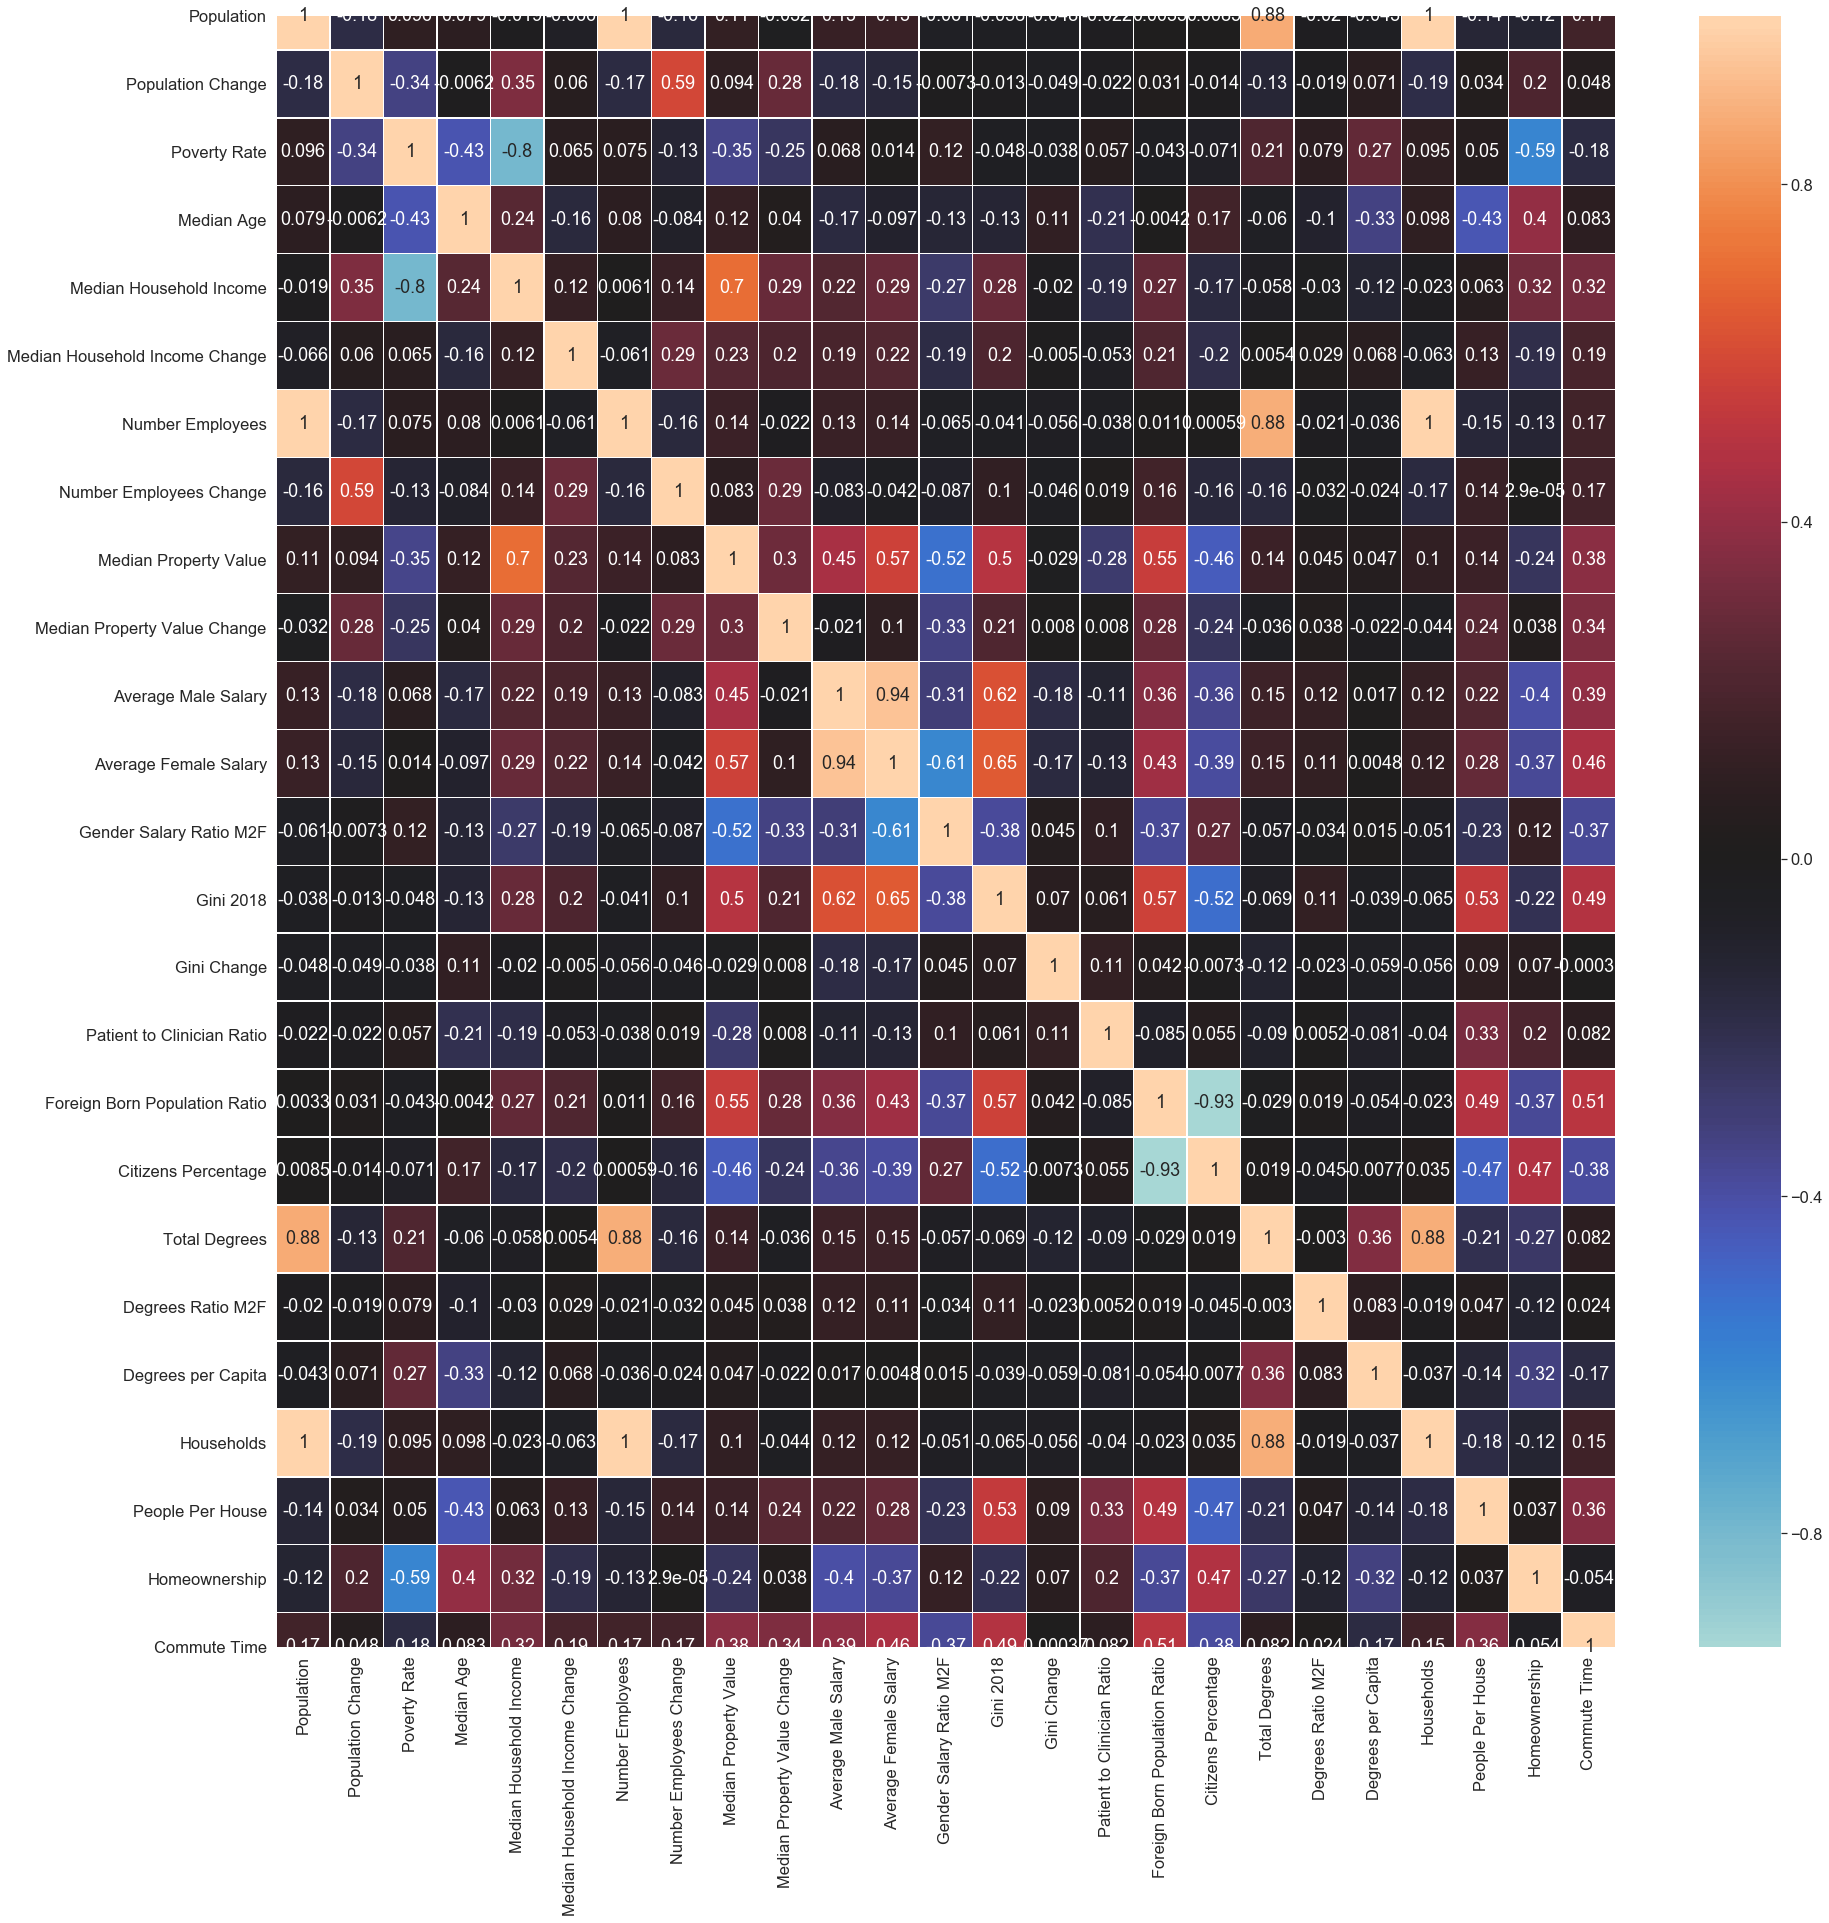

In [126]:
corrMatrix = onlyCon_df.corr()
plt.figure(figsize=(30,30))
sns.set(font_scale=1.5)
sns.heatmap(corrMatrix, annot=True, center=0, linewidths=0.5)
plt.show()

##### Extract geolocation data for each city and create some visualizations

In [121]:
m = folium.Map(location=[37.0902,-95.7129], no_touch=True ,zoom_start=4, min_zoom=4, max_zoom=7)

for i in range(0,len(cities)):
    folium.CircleMarker(
    location=[cities.iloc[i]['Latitude'],cities.iloc[i]['Longitude']],
    popup = cities.iloc[i]['City'],
    radius= cities.iloc[i]['Median Property Value']/cities.iloc[i]['Median Household Income']*2,
    color='crimson',
    fill = True,
    fill_color='crimson'
    ).add_to(m)
    
# for i in range(0,len(cities)):
#     folium.CircleMarker(
#     location=[cities.iloc[i]['Latitude'],cities.iloc[i]['Longitude']],
#     popup = cities.iloc[i]['City'],
#     radius= cities.iloc[i]['Median Property Value']/100000,
#     color='blue',
#     fill = True,
#     fill_color='crimson'
#     ).add_to(m)

m